In [0]:
# Installing additional packages needed for the Analysis
!pip install geopandas

     |████████████████████████████████| 931kB 1.8MB/s 
     |████████████████████████████████| 14.7MB 301kB/s 
     |████████████████████████████████| 10.4MB 36.2MB/s 


In [0]:
# a) Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

import seaborn as sns
import geopandas as gpd

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import pathlib
import urllib.request
from datetime import datetime


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Loading all the necessary datasets (IMPORTANT- Requires an active internet connection)
movie_data = pd.read_csv("https://raw.githubusercontent.com/aadityanaik/movielens-analysis/master/movies.dat",
                       sep="::", header=None, names=['MovieID','Title','Genres'], 
                       dtype={'MovieID': np.int32, 'Title': np.str, 'Genres': np.str}, encoding = 'latin1', engine='python')
users_data = pd.read_csv("https://raw.githubusercontent.com/aadityanaik/movielens-analysis/master/users.dat",
                       sep="::", header=None, names=['UserID','Gender','Age','Occupation','Zip-code'], 
    dtype={'UserID': np.int32, 'Gender': np.str, 'Age': np.int32, 'Occupation' : np.int32, 'Zip-code': np.str}, engine='python')
ratings_data = pd.read_csv("https://raw.githubusercontent.com/aadityanaik/movielens-analysis/master/ratings.dat",
                       sep="::", header=None, names=['UserID','MovieID','Rating','Timestamp'], 
                dtype={'UserID': np.int32, 'MovieID': np.int32, 'Rating': np.int32, 'Timestamp' : np.str}, engine='python')
zip_data = pd.read_csv("https://raw.githubusercontent.com/aadityanaik/movielens-analysis/master/zip_code_database.csv")

We now take a look at the head of each dataset

In [0]:
movie_data.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
users_data.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [0]:
ratings_data.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [0]:
zip_data.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


We now perform preprocessing on these datasets to get the tables that will be useful for us

In [0]:
# Convert all zip codes to String
zip_data['zip'] = zip_data['zip'].astype(str)

# Make sure all zip codes are of length 5
zip_data['zip'] = zip_data['zip'].apply(lambda x: x.zfill(5))

In [0]:
# Showing the number of users per zip-code
users_data['Zip-code'].value_counts()

48104    19
22903    18
94110    17
55104    17
55105    16
         ..
33186     1
67204     1
48154     1
37774     1
32726     1
Name: Zip-code, Length: 3439, dtype: int64

In [0]:
# Merging the user data with the zip data to get the state in which each user lives
mapping = pd.merge(users_data, zip_data, how="left", left_on=['Zip-code'], right_on=['zip'], validate='m:m')
# Dropping unnecessary columns
mapping= mapping[['UserID', 'Gender', 'Age', 'Occupation', 'zip','state','county','timezone']]
mapping.head()

,UserID,Gender,Age,Occupation,zip,state,county,timezone
0,1,F,1,10,48067,MI,Oakland County,America/Detroit
1,2,M,56,16,70072,LA,Jefferson Parish,America/Chicago
2,3,M,25,15,55117,MN,Ramsey County,America/Chicago
3,4,M,45,7,02460,MA,Middlesex County,America/New_York
4,5,M,25,20,55455,MN,Hennepin County,America/Chicago


In [0]:
# Finding the number of reviews per user
ratings_data.groupby(['UserID']).size()

UserID
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [0]:
# Average rating given by each user
ratings_data.groupby(['UserID']).agg({'Rating':'mean'})

,Rating
UserID,
1,4.188679
2,3.713178
3,3.901961
4,4.190476
5,3.146465
...,...
6036,3.302928
6037,3.717822
6038,3.800000


In [0]:
# Number of ratings given to each movie
ratings_data.groupby(['MovieID']).size().sort_values()

MovieID
402        1
2214       1
3382       1
2217       1
2218       1
        ... 
480     2672
1210    2883
1196    2990
260     2991
2858    3428
Length: 3706, dtype: int64

In [0]:
# Average rating for each movie
avg_rating = ratings_data.groupby(['MovieID']).agg({'Rating':'mean'})
print(avg_rating)

           Rating
MovieID          
1        4.146846
2        3.201141
3        3.016736
4        2.729412
5        3.006757
...           ...
3948     3.635731
3949     4.115132
3950     3.666667
3951     3.900000
3952     3.780928

[3706 rows x 1 columns]


In [0]:
# Merging Movie data with it's average rating
movie_data = pd.merge(movie_data, avg_rating, on=["MovieID"])
movie_data.tail()

,MovieID,Title,Genres,Rating
3701,3948,Meet the Parents (2000),Comedy,3.635731
3702,3949,Requiem for a Dream (2000),Drama,4.115132
3703,3950,Tigerland (2000),Drama,3.666667
3704,3951,Two Family House (2000),Drama,3.900000
3705,3952,"Contender, The (2000)",Drama|Thriller,3.780928


In [0]:
# Sorting wrt average ratings in descending order
top_movies = movie_data['Rating'].sort_values(ascending= False).head(10)
top_movies.head()

3152    5.0
2955    5.0
3367    5.0
3414    5.0
3054    5.0
Name: Rating, dtype: float64

In [0]:
# Converting the Genres into a more usable format (binary vectors to represent the genre)
movie_data_g = pd.concat([movie_data, movie_data.Genres.str.get_dummies(sep='|')], axis=1)  
movie_data_g.head()

,MovieID,Title,Genres,Rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,4.146846,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.201141,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,3.016736,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,2.729412,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,3.006757,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Get a list of genres
all_genres_i = movie_data.Genres.str.get_dummies(sep='|').columns
print(all_genres_i)

Index(['Action', 'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [0]:
# Getting average rating for each genre

columns = ['genres']
all_genres= pd.DataFrame(all_genres_i, columns=columns)
all_genres.insert(1, "Rating", 0)
for iter in all_genres_i:
    #print(iter)
    x= movie_data_g.loc[movie_data_g[iter] == 1].agg({'Rating':'mean'})
    all_genres.loc[(all_genres.genres == iter),'Rating']= x[0]
all_genres

,genres,Rating
0,Action,3.098295
1,Adventure,3.099664
2,Animation,3.358366
3,Children's,3.006325
4,Comedy,3.159924
5,Crime,3.385133
6,Documentary,3.687885
7,Drama,3.415331
8,Fantasy,3.098860
9,Film-Noir,3.806448


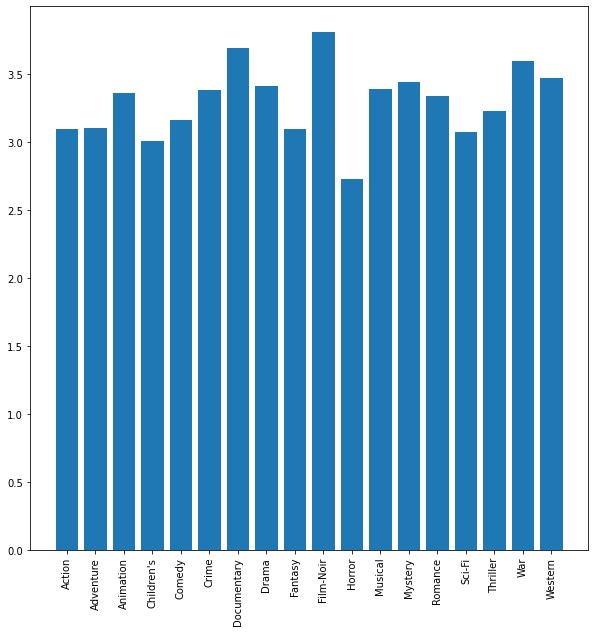

In [0]:
# Plotting the average ratings in a bar graph
plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
plt.bar(all_genres['genres'], all_genres['Rating'])
plt.show()

In [0]:
# Merging tables to get final workable table

u_r_map = pd.merge(mapping, ratings_data, how="left", on=["UserID"], validate='m:m')
u_r_m_map = pd.merge(u_r_map, movie_data, how="left", on=["MovieID"])
final_map = pd.concat([u_r_m_map,u_r_m_map.Genres.str.get_dummies(sep='|')], axis=1) 
final_map

,UserID,Gender,Age,Occupation,zip,state,county,timezone,MovieID,Rating_x,Timestamp,Title,Genres,Rating_y,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,F,1,10,48067,MI,Oakland County,America/Detroit,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,4.390725,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,F,1,10,48067,MI,Oakland County,America/Detroit,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,3.464762,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,F,1,10,48067,MI,Oakland County,America/Detroit,914,3,978301968,My Fair Lady (1964),Musical|Romance,4.154088,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,1,F,1,10,48067,MI,Oakland County,America/Detroit,3408,4,978300275,Erin Brockovich (2000),Drama,3.863878,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,F,1,10,48067,MI,Oakland County,America/Detroit,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,3.854375,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,M,25,6,11106,NY,Queens County,America/New_York,1091,1,956716541,Weekend at Bernie's (1989),Comedy,2.793566,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1000205,6040,M,25,6,11106,NY,Queens County,America/New_York,1094,5,956704887,"Crying Game, The (1992)",Drama|Romance|War,3.731489,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
1000206,6040,M,25,6,11106,NY,Queens County,America/New_York,562,5,956704746,Welcome to the Dollhouse (1995),Comedy|Drama,3.799163,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1000207,6040,M,25,6,11106,NY,Queens County,America/New_York,1096,4,956715648,Sophie's Choice (1982),Drama,3.976744,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
# To show the usefulness of the final map, we show the result of grouping by User_ID
groups = final_map.groupby(['UserID'])
app = groups.apply(lambda x: x[x['Fantasy'] == 1])
app

UserID Gender  Age  Occupation  ... Sci-Fi Thriller War Western
UserID                                          ...                            
1      19            1      F    1          10  ...      0        0   0       0
       26            1      F    1          10  ...      1        0   0       0
       44            1      F    1          10  ...      1        0   0       0
2      60            2      M   56          16  ...      1        0   0       0
3      197           3      M   25          15  ...      0        0   0       0
...                ...    ...  ...         ...  ...    ...      ...  ..     ...
6040   999929     6040      M   25           6  ...      1        0   0       0
       999944     6040      M   25           6  ...      0        0   0       0
       999948     6040      M   25           6  ...      0        0   0       0
       1000198    6040      M   25           6  ...      1        0   0       0
       1000208    6040      M   25           6  ...      1        0   0       0

[36301 rows x 32 columns]

We now proceed to the data visualization.

We perform 5 main types of visualization, each of which will be described in the following cells.

First, we look at showing the statewise distribution of preferred genres by location.

Here, we consider the most popular genre in each state by taking a count of the number of reviews posted per genre in said states, and then plotted them over a map of the Mainland United States colour coded according to the genre.


In [0]:
# Getting the shape files for the states
# NOTE- This requires an active internet connection

states_shape_filename = "cb_2018_us_state_20m.zip"
file_link = f"https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
states_shape_file = pathlib.Path(states_shape_filename)

with urllib.request.urlopen(file_link) as resp, open(states_shape_file, "wb") as f:
  f.write(resp.read())

In [0]:
# Reading the downloaded states shape files
states_gdf = gpd.read_file(f"zip://{states_shape_file}")
states_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [0]:
# Finding the preferred genre for each state

state_genre_count = {}
state_films_total = {}
i = 0
for _, row in final_map.iterrows():
  # if i >= 5:
  #   break
  state = row['state']
  genres = row['Genres'].split('|')
  # print(state, genres)

  if state not in state_genre_count:
    state_genre_count[state] = {}
  
  if state not in state_films_total:
    state_films_total[state] = 1
  else:
    state_films_total[state] += 1

  for genre in genres:
    if genre not in state_genre_count[state]:
      state_genre_count[state][genre] = 1
    else:
      state_genre_count[state][genre] += 1

  # i += 1

for state in state_genre_count:
  for genre in state_genre_count[state]:
    state_genre_count[state][genre] /= state_films_total[state]

statewise_pop_genre = []

for state in state_genre_count:
  max_count = 0
  max_genre = ""
  for genre in state_genre_count[state]:
    if state_genre_count[state][genre] > max_count:
      max_count = state_genre_count[state][genre]
      max_genre = genre
    elif state_genre_count[state][genre] == max_count:
      max_genre += "|" + genre
  statewise_pop_genre.append([state, max_genre])

statewise_pop_genre = pd.DataFrame(data = statewise_pop_genre, columns = ['STUSPS', 'genre'])

statewise_pop_genre.head()

,STUSPS,genre
0,MI,Comedy
1,LA,Comedy
2,MN,Comedy
3,MA,Comedy
4,CT,Comedy


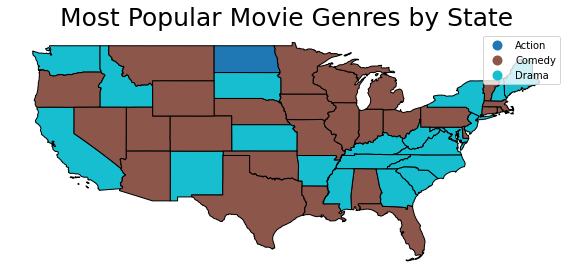

In [0]:
# Plotting the preferred genre for each state
loc_genre = states_gdf.merge(statewise_pop_genre, left_on='STUSPS', right_on='STUSPS')
loc_genre = loc_genre.loc[~loc_genre['STUSPS'].isin(['PR', 'HI', 'AK'])]
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Most Popular Movie Genres by State', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')
loc_genre.plot(column='genre', linewidth=1, ax=ax, edgecolor='0', legend='True')

Plotting a heatmap showing the average ratings of age groups for each genre

The average ratings across age ranges can be accurately represented using heatmaps, such the the colour of each cell in the heatmap corresponds to the average rating users of a particular age group gave movies of each Genre as a whole. Below, we filter the main dataset by Genre and aggregate the ratings by average across age groups.*italicized text*

In [0]:
# Renaming data frames
final_ratings_map = pd.DataFrame(final_map)

final_ratings_map = final_ratings_map.rename(columns = {"Rating_x": "Rating"})
final_ratings_map = final_ratings_map.rename(columns = {"Children's": "Children"})
final_ratings_map = final_ratings_map.rename(columns = {"Sci-Fi": "SciFi"})
final_ratings_map = final_ratings_map.rename(columns = {"Film-Noir": "FilmNoir"})

[Text(0.5, 1.0, 'Age Range Vs. Genre Heatmap where Cell Values represent Average Rating.\n')]

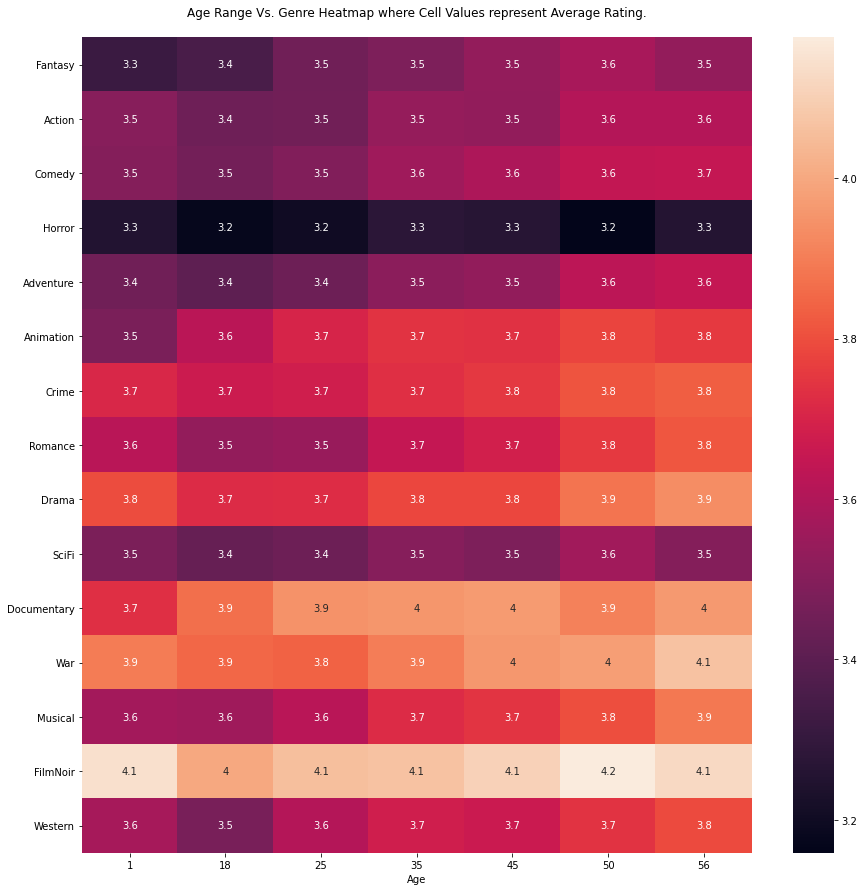

In [0]:
fantasy_df = final_ratings_map.query("Fantasy == 1")
fantasy_df = fantasy_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Fantasy"})

action_df = final_ratings_map.query("Action == 1")
action_df = action_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Action"})

comedy_df = final_ratings_map.query("Comedy == 1")
comedy_df = comedy_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Comedy"})

horror_df = final_ratings_map.query("Horror == 1")
horror_df = horror_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Horror"})

adventure_df = final_ratings_map.query("Adventure == 1")
adventure_df = adventure_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Adventure"})

animation_df = final_ratings_map.query("Animation == 1")
animation_df = animation_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Animation"})

crime_df = final_ratings_map.query("Crime == 1")
crime_df = crime_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Crime"})

romance_df = final_ratings_map.query("Romance == 1")
romance_df = romance_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Romance"})

childrens_df = final_ratings_map.query("Children == 1")
childrens_df = childrens_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Children"})

drama_df = final_ratings_map.query("Drama == 1")
drama_df = drama_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Drama"})

scifi_df = final_ratings_map.query(r"SciFi == 1")
scifi_df = scifi_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "SciFi"})

doc_df = final_ratings_map.query("Documentary == 1")
doc_df = doc_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Documentary"})

war_df = final_ratings_map.query("War == 1")
war_df = war_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "War"})

musical_df = final_ratings_map.query("Musical == 1")
musical_df = musical_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Musical"})

mystery_df = final_ratings_map.query("Mystery == 1")
mystery_df = mystery_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Mystery"})

thriller_df = final_ratings_map.query("Thriller == 1")
thriller_df = thriller_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Thriller"})

filmnoir_df = final_ratings_map.query("FilmNoir == 1")
filmnoir_df = filmnoir_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "FilmNoir"})

western_df = final_ratings_map.query("Western == 1")
western_df = western_df.groupby('Age').agg({'Rating': "mean"}).rename(columns = {"Rating": "Western"})

heat_df = fantasy_df.join(action_df, how = 'left', on = 'Age')
heat_df = heat_df.join(comedy_df, how = 'left', on = 'Age')
heat_df = heat_df.join(horror_df, how = 'left', on = 'Age')
heat_df = heat_df.join(adventure_df, how = 'left', on = 'Age')
heat_df = heat_df.join(animation_df, how = 'left', on = 'Age')
heat_df = heat_df.join(crime_df, how = 'left', on = 'Age')
heat_df = heat_df.join(romance_df, how = 'left', on = 'Age')
heat_df = heat_df.join(drama_df, how = 'left', on = 'Age')
heat_df = heat_df.join(scifi_df, how = 'left', on = 'Age')
heat_df = heat_df.join(doc_df, how = 'left', on = 'Age')
heat_df = heat_df.join(war_df, how = 'left', on = 'Age')
heat_df = heat_df.join(musical_df, how = 'left', on = 'Age')
heat_df = heat_df.join(filmnoir_df, how = 'left', on = 'Age')
heat_df = heat_df.join(western_df, how = 'left', on = 'Age')

plt.subplots(figsize=(15, 15))
sns.heatmap(heat_df.T, annot = True).set(title="Age Range Vs. Genre Heatmap where Cell Values represent Average Rating.\n")


Plotting a bar graph to show the average ratings of genres as given by each gender.

The average ratings across Genres can be accurately represented using bifurcated Bar Plots, such the the height of each bar in the plot corresponds to the average rating users of a particular age group gave movies of each Genre as a whole. Meanwhile, two bars in different colours uniquely represent Male and Female ratings for each Genre. Below, we filter the main dataset by Genre and aggregate the ratings by average across Gender.

[Text(0.5, 1.0, 'Average Rating Vs. Genre Bar Chart Grouped By Gender.\n')]

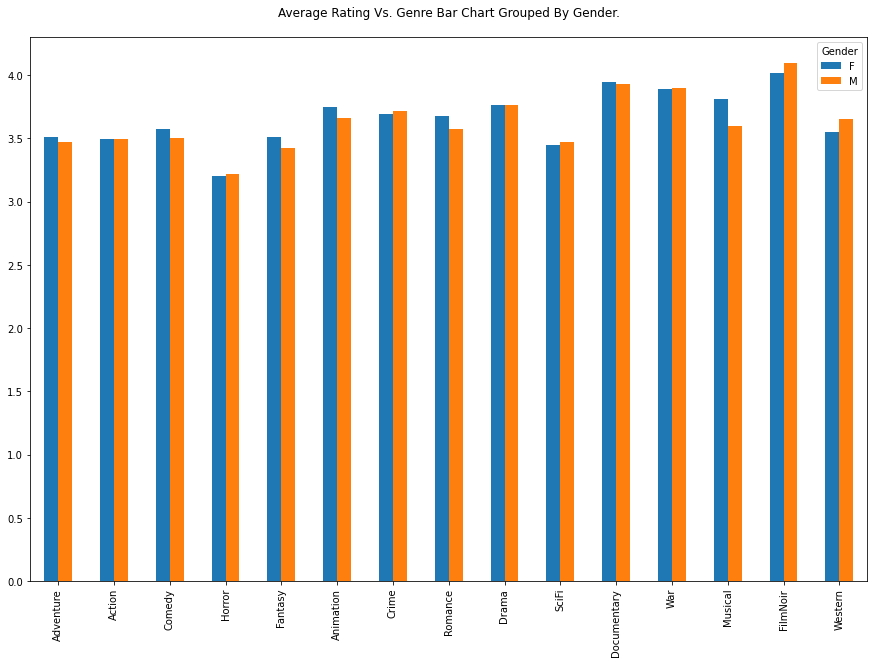

In [0]:
gen_ratings_by_ad = final_ratings_map.query('Adventure == 1')
gen_ratings_by_ad = gen_ratings_by_ad.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Adventure"})

gen_ratings_by_action = final_ratings_map.query("Action == 1")
gen_ratings_by_action = gen_ratings_by_action.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Action"})

gen_ratings_by_f = final_ratings_map.query('Fantasy == 1')
gen_ratings_by_f = gen_ratings_by_f.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Fantasy"})

gen_ratings_by_comedy = final_ratings_map.query('Comedy == 1')
gen_ratings_by_comedy = gen_ratings_by_comedy.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Comedy"})

gen_ratings_by_horror = final_ratings_map.query('Horror == 1')
gen_ratings_by_horror = gen_ratings_by_horror.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Horror"})

gen_ratings_by_anim = final_ratings_map.query('Animation == 1')
gen_ratings_by_anim = gen_ratings_by_anim.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Animation"})

gen_ratings_by_crime = final_ratings_map.query('Crime == 1')
gen_ratings_by_crime = gen_ratings_by_crime.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Crime"})

gen_ratings_by_rom = final_ratings_map.query('Romance == 1')
gen_ratings_by_rom = gen_ratings_by_rom.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Romance"})

gen_ratings_by_drama = final_ratings_map.query('Drama == 1')
gen_ratings_by_drama = gen_ratings_by_drama.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Drama"})

gen_ratings_by_scifi = final_ratings_map.query('SciFi == 1')
gen_ratings_by_scifi = gen_ratings_by_scifi.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "SciFi"})

gen_ratings_by_docu = final_ratings_map.query('Documentary == 1')
gen_ratings_by_docu = gen_ratings_by_docu.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Documentary"})

gen_ratings_by_war = final_ratings_map.query('War == 1')
gen_ratings_by_war = gen_ratings_by_war.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "War"})

gen_ratings_by_music = final_ratings_map.query('Musical == 1')
gen_ratings_by_music = gen_ratings_by_music.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Musical"})

gen_ratings_by_fn = final_ratings_map.query('FilmNoir == 1')
gen_ratings_by_fn = gen_ratings_by_fn.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "FilmNoir"})

gen_ratings_by_west = final_ratings_map.query('Western == 1')
gen_ratings_by_west = gen_ratings_by_west.groupby('Gender').agg({"Rating": "mean"}).rename(columns = {"Rating": "Western"})

bar_df = gen_ratings_by_ad.join(gen_ratings_by_action, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_comedy, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_horror, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_f, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_anim, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_crime, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_rom, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_drama, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_scifi, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_docu, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_war, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_music, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_fn, how = "left", on = "Gender")
bar_df = bar_df.join(gen_ratings_by_west, how = "left", on = "Gender")

bar_df.T.plot.bar(figsize=(15, 10), by = "Gender").set(title="Average Rating Vs. Genre Bar Chart Grouped By Gender.\n")

Plotting a heatmap for the average ratings of each genre given by people from each occupation.

The average ratings across occupation can be accurately represented using heatmaps, such the the colour of each cell in the heatmap corresponds to the average rating users of a particular occupation gave movies of each Genre as a whole. Below, we filter the main dataset by Genre and aggregate the ratings by average across occupations.

Occupation is chosen from the following choices: 0: "other" or not specified 1: "academic/educator" 2: "artist" 3: "clerical/admin" 4: "college/grad student" 5: "customer service" 6: "doctor/health care" 7: "executive/managerial" 8: "farmer" 9: "homemaker" 10: "K-12 student" 11: "lawyer" 12: "programmer" 13: "retired" 14: "sales/marketing" 15: "scientist" 16: "self-employed" 17: "technician/engineer" 18: "tradesman/craftsman" 19: "unemployed" * 20: "writer"

[Text(0.5, 1.0, 'Occupation Vs. Genre Heatmap where Cell Values represent Average Rating.\n')]

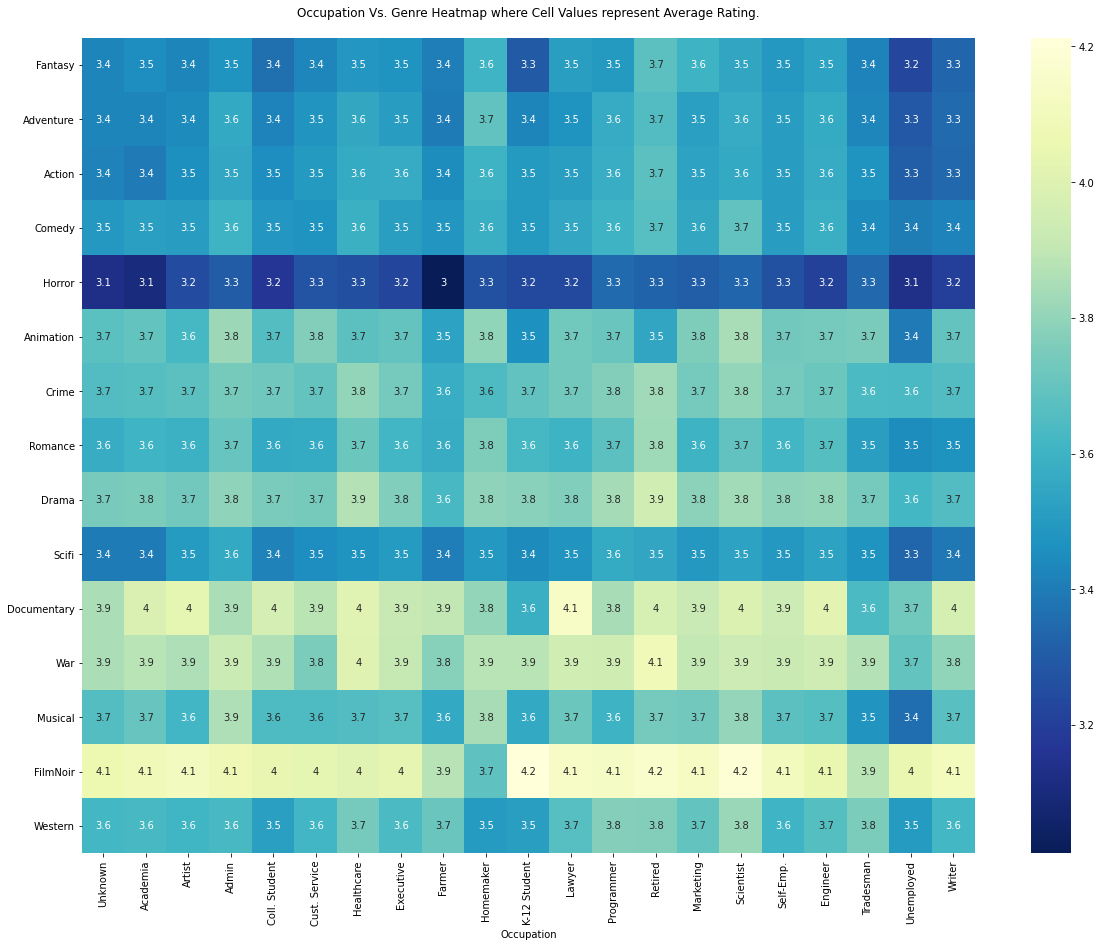

In [0]:
fantasy_df_occ = final_ratings_map.query("Fantasy == 1")
fantasy_df_occ = fantasy_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Fantasy"})


ad_df_occ = final_ratings_map.query("Adventure == 1")
ad_df_occ = ad_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Adventure"})

ac_df_occ = final_ratings_map.query("Action == 1")
ac_df_occ = ac_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Action"})

comedy_df_occ = final_ratings_map.query("Comedy == 1")
comedy_df_occ = comedy_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Comedy"})

horror_df_occ = final_ratings_map.query("Horror == 1")
horror_df_occ = horror_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Horror"})

anim_df_occ = final_ratings_map.query("Animation == 1")
anim_df_occ = anim_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Animation"})

crime_df_occ = final_ratings_map.query("Crime == 1")
crime_df_occ = crime_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Crime"})

rom_df_occ = final_ratings_map.query("Romance == 1")
rom_df_occ = rom_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Romance"})

drama_df_occ = final_ratings_map.query("Drama == 1")
drama_df_occ = drama_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Drama"})

scifi_df_occ = final_ratings_map.query("SciFi == 1")
scifi_df_occ = scifi_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Scifi"})

docu_df_occ = final_ratings_map.query("Documentary == 1")
docu_df_occ = docu_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Documentary"})

war_df_occ = final_ratings_map.query("War == 1")
war_df_occ = war_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "War"})

musical_df_occ = final_ratings_map.query("Musical == 1")
musical_df_occ = musical_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Musical"})

fn_df_occ = final_ratings_map.query("FilmNoir == 1")
fn_df_occ = fn_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "FilmNoir"})

west_df_occ = final_ratings_map.query("Western == 1")
west_df_occ = west_df_occ.groupby("Occupation").agg({"Rating": "mean"}).T.rename(index={"Rating": "Western"})


occ_df = pd.concat([fantasy_df_occ, ad_df_occ, ac_df_occ, comedy_df_occ, horror_df_occ, anim_df_occ, crime_df_occ, rom_df_occ, drama_df_occ, scifi_df_occ, docu_df_occ, war_df_occ, musical_df_occ, fn_df_occ, west_df_occ])

plt.subplots(figsize=(20, 15))
occupations = ["Unknown", "Academia", "Artist", "Admin", "Coll. Student", "Cust. Service", "Healthcare", "Executive", "Farmer", "Homemaker", "K-12 Student", "Lawyer", "Programmer", "Retired", "Marketing", "Scientist", "Self-Emp.", "Engineer", "Tradesman", "Unemployed", "Writer"]
sns.heatmap(data = occ_df, annot = True, xticklabels=occupations, cmap="YlGnBu_r").set(title="Occupation Vs. Genre Heatmap where Cell Values represent Average Rating.\n")

Now we plot the timeseries graph of the average genre ratings over various intervals of time.

We have two forms of timeseries- monthwise and yearwise. In yearwise, we look at average ratings for each genre per year and plot them as a timeseries graph, whereas in monthwise, we consider the average ratings of each genre per month. The months range from 2000-04 (April 2000) to 2003-02 (February 2003).


In [0]:
# Finding the average rating of each genre by year
year_genre_popularity = {}
year_genre_ratings = {}
years = []

year_map = pd.DataFrame(final_map)

year_map['Year'] = year_map.apply(lambda row : int(datetime.utcfromtimestamp(int(row['Timestamp'])).strftime('%Y')), axis=1)

yearwise_genre_rating = {}
for genre in all_genres['genres']:
  year_grouped = year_map.groupby(['Year', genre])
  app = year_grouped.agg({'Rating_x' : ['mean']})
  app = app.reset_index()
  app = pd.DataFrame(app[app[genre] == 1])

  for _, row in app.iterrows():
    y, r = int(row.values[0]), float(row.values[2])
    if genre not in yearwise_genre_rating:
      yearwise_genre_rating[genre] = {}
    yearwise_genre_rating[genre][y] = r

yearwise_genre_rating_dataframe = pd.DataFrame(yearwise_genre_rating)

yearwise_genre_rating_dataframe

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
2000,3.501721,3.487544,3.699725,3.431261,3.533002,3.716778,3.941075,3.774272,3.455756,4.079832,3.225914,3.669016,3.671110,3.615235,3.477517,3.581210,3.902247,3.641338
2001,3.378504,3.368108,3.549833,3.357689,3.441916,3.651896,3.879336,3.709585,3.378249,4.026999,3.099426,3.625631,3.653816,3.538701,3.345320,3.473826,3.793912,3.603102
2002,3.303536,3.280788,3.570975,3.281174,3.367645,3.518811,3.910204,3.657546,3.254374,3.956522,3.115517,3.655959,3.588369,3.506991,3.289716,3.420596,3.726646,3.587234
2003,3.378539,3.397143,3.422680,3.244792,3.404592,3.745020,3.704918,3.687949,3.376147,4.236364,2.892157,3.642336,3.625000,3.574000,3.152273,3.431862,3.934783,3.554054


In [0]:
# Finding the average rating of each genre by month
month_map = pd.DataFrame(final_map)

month_map['Month'] = month_map.apply(lambda row : datetime.utcfromtimestamp(int(row['Timestamp'])).strftime('%Y-%m'), axis=1)

monthwise_genre_rating = {}

for genre in all_genres['genres']:
  month_grouped = month_map.groupby(['Month', genre])
  app = month_grouped.agg({'Rating_x' : ['mean']})
  app = app.reset_index()
  app = pd.DataFrame(app[app[genre] == 1])
  for _, row in app.iterrows():
    m, r = row.values[0], float(row.values[2])

    if genre not in monthwise_genre_rating:
      monthwise_genre_rating[genre] = {}

    monthwise_genre_rating[genre][m] = r

monthwise_genre_rating_dataframe = pd.DataFrame(monthwise_genre_rating)

monthwise_genre_rating_dataframe

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
2000-04,3.525162,3.468177,3.680525,3.429082,3.420742,3.700456,4.112903,3.707098,3.503067,4.250000,3.300000,3.643443,3.748359,3.543959,3.531193,3.607013,3.904092,3.489083
2000-05,3.520630,3.488710,3.715075,3.421314,3.536995,3.750454,3.922449,3.805530,3.472100,4.106368,3.252116,3.691253,3.772546,3.654972,3.488832,3.634570,3.916632,3.614783
2000-06,3.525611,3.491458,3.640695,3.401523,3.588226,3.790875,4.027778,3.796137,3.431144,4.099647,3.319428,3.631601,3.735894,3.636203,3.506269,3.644718,3.913909,3.654475
2000-07,3.516047,3.518291,3.712869,3.469858,3.586596,3.750442,4.000000,3.798336,3.481985,4.098269,3.191707,3.701962,3.731410,3.675691,3.499896,3.620848,3.906446,3.655527
2000-08,3.518174,3.494874,3.727545,3.418880,3.501684,3.705948,3.861944,3.749260,3.461221,4.068730,3.240224,3.650852,3.653795,3.589420,3.480143,3.585479,3.897484,3.707112
2000-09,3.501183,3.500575,3.737913,3.476619,3.544629,3.724592,3.909756,3.800177,3.506964,4.043384,3.183087,3.748463,3.659614,3.639775,3.501697,3.594875,3.919865,3.686117
2000-10,3.526087,3.507561,3.722925,3.505747,3.583698,3.733452,4.011019,3.785719,3.521574,4.031637,3.259627,3.722684,3.706810,3.622645,3.499856,3.595410,3.921401,3.684270
2000-11,3.473170,3.467142,3.665646,3.394381,3.524370,3.702825,3.939119,3.766631,3.416182,4.095238,3.199241,3.640397,3.639776,3.599472,3.448502,3.544955,3.893238,3.594134
2000-12,3.501810,3.490637,3.733115,3.484841,3.520731,3.678587,3.925884,3.771918,3.475993,4.017152,3.243810,3.696524,3.618807,3.600653,3.486800,3.560809,3.900706,3.613017
2001-01,3.456774,3.435806,3.627252,3.404240,3.473185,3.728053,3.774725,3.729466,3.423698,4.011029,3.133449,3.652934,3.654430,3.586513,3.400465,3.514411,3.787671,3.626140


Each plot for the genre timeseries is distributed into 3 parts with 6 genres plotted each.

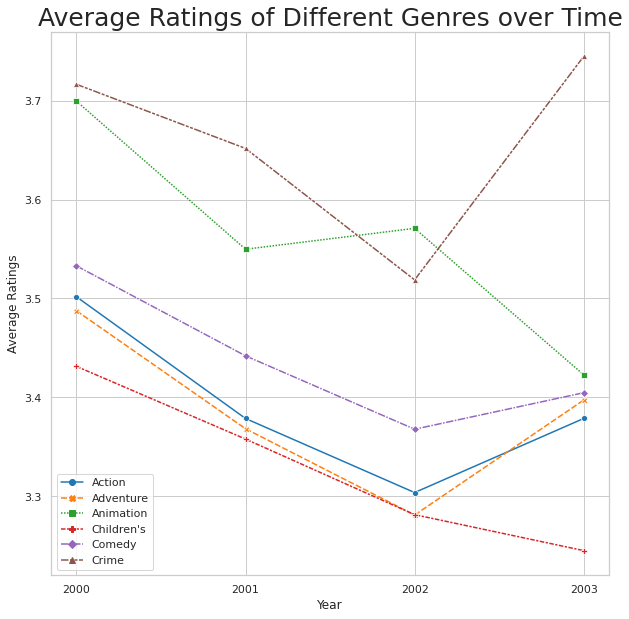

In [0]:
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid")
ax = sns.lineplot(data=yearwise_genre_rating_dataframe.iloc[:,:6], palette="tab10", markers=True)
ax.set_title('Average Ratings of Different Genres over Time', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.set_xlabel('Year')
ax.set_ylabel('Average Ratings')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

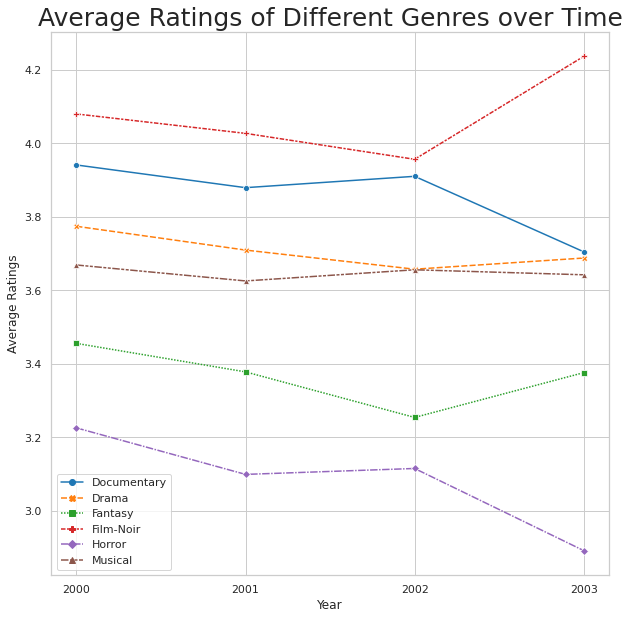

In [0]:
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid")
ax = sns.lineplot(data=yearwise_genre_rating_dataframe.iloc[:,6:12], palette="tab10", markers=True)
ax.set_title('Average Ratings of Different Genres over Time', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.set_xlabel('Year')
ax.set_ylabel('Average Ratings')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

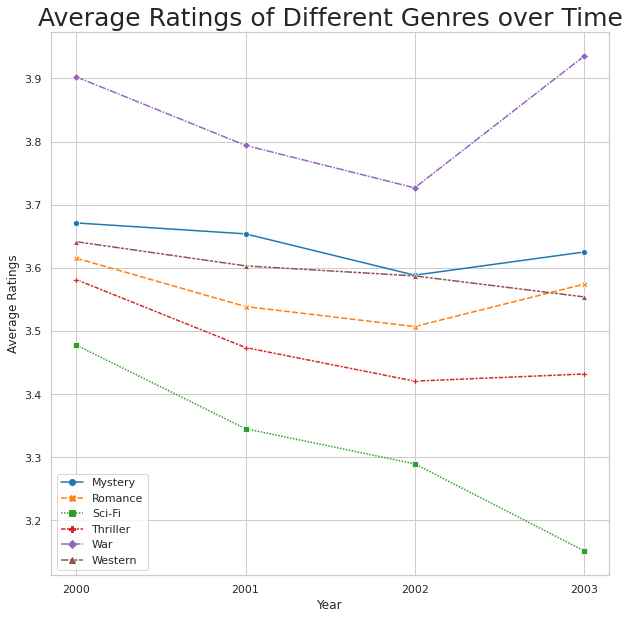

In [0]:
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid")
ax = sns.lineplot(data=yearwise_genre_rating_dataframe.iloc[:,12:], palette="tab10", markers=True)
ax.set_title('Average Ratings of Different Genres over Time', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.set_xlabel('Year')
ax.set_ylabel('Average Ratings')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

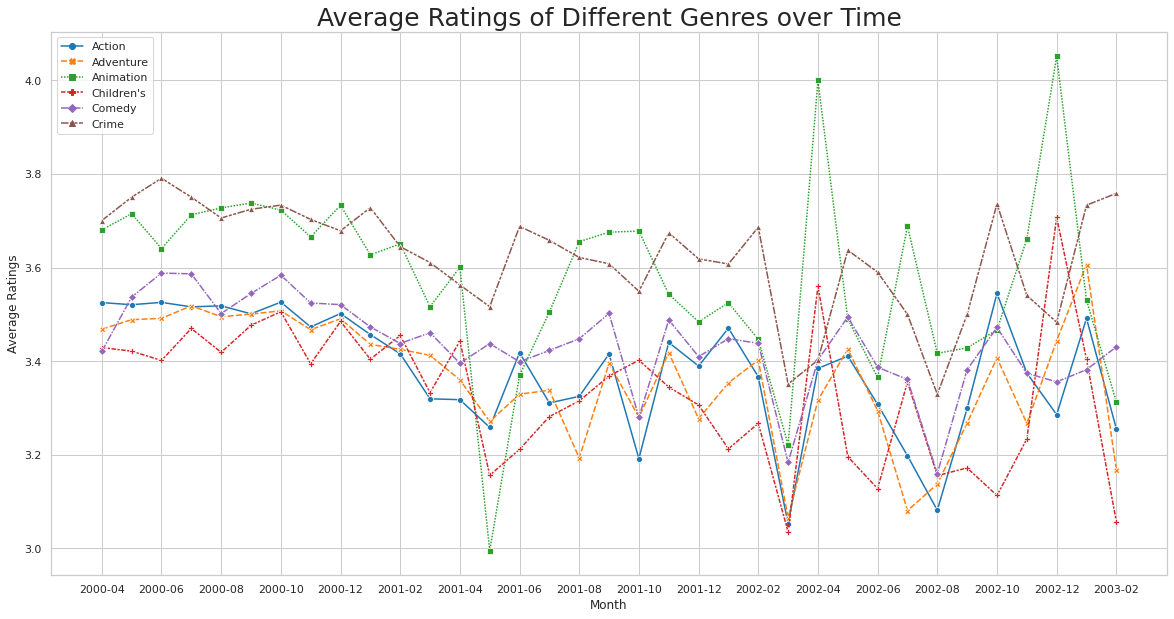

In [0]:
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")
ax = sns.lineplot(data=monthwise_genre_rating_dataframe.iloc[:,:6], palette="tab10", markers=True)
ax.set_title('Average Ratings of Different Genres over Time', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.set_xlabel('Month')
ax.set_ylabel('Average Ratings')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()

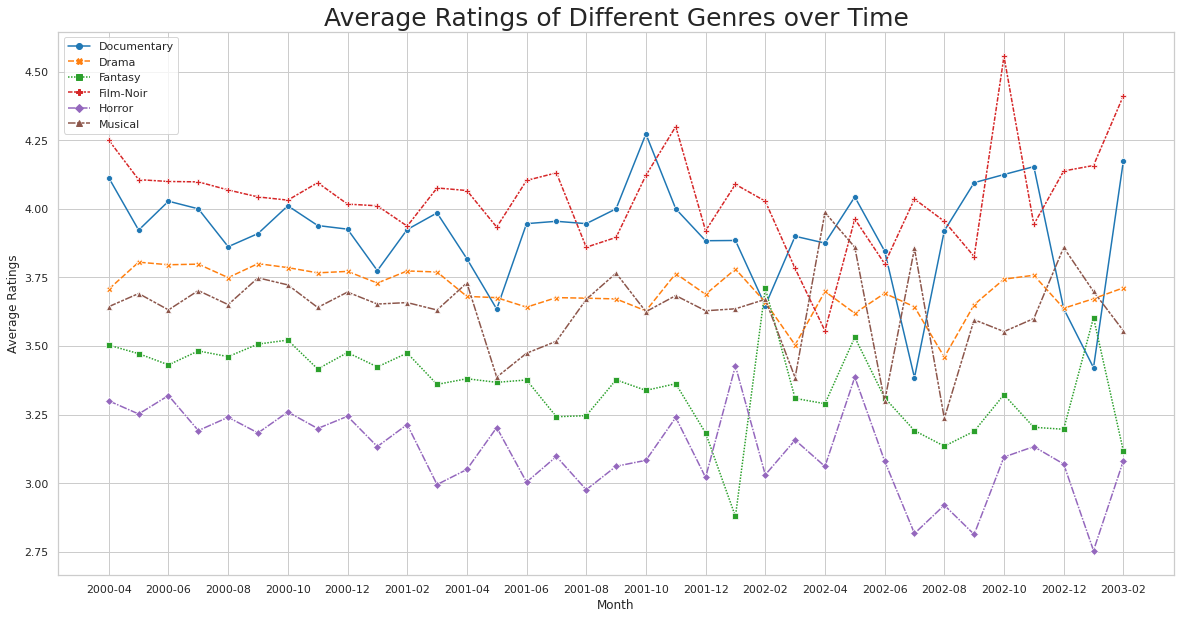

In [0]:
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")
ax = sns.lineplot(data=monthwise_genre_rating_dataframe.iloc[:,6:12], palette="tab10", markers=True)
ax.set_title('Average Ratings of Different Genres over Time', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.set_xlabel('Month')
ax.set_ylabel('Average Ratings')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()

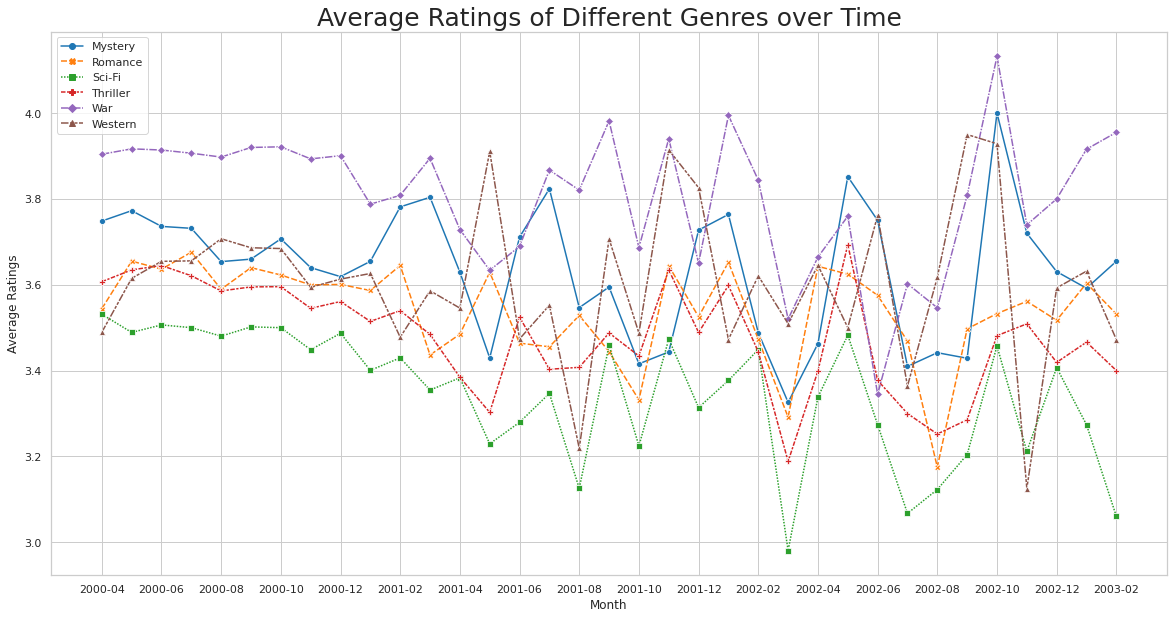

In [0]:
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")
ax = sns.lineplot(data=monthwise_genre_rating_dataframe.iloc[:,12:], palette="tab10", markers=True)
ax.set_title('Average Ratings of Different Genres over Time', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.set_xlabel('Month')
ax.set_ylabel('Average Ratings')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()

According to the above visualizations, we see that it is straightforward to be able to predict the user's favourite genre given certain information about the user. For now, we consider Age Group, Gender, Occupation and State.

In [0]:
# Find the user's favourite genre and setting up the final dataset

user_list = list(users_data['UserID'])
user_list.insert(0,0)
df3=pd.DataFrame(user_list, columns=['UserID'])
    
for iter in all_genres_i:
    c=0
    groups = final_map.groupby('UserID')[iter].sum()
    groups= pd.DataFrame(data=groups)
    c=c+1
    df3.insert(c,iter,groups)

df3 = df3.iloc[1:]
df3['MaxGenre'] = df3[df3.columns.difference(['UserID'])].idxmax(axis=1)

df4 = df3.copy()
df4 = df4[['UserID','MaxGenre']]
df4 = pd.merge(df4,mapping, how="left", on='UserID' )
df4=df4[['UserID','MaxGenre','Gender','Age','Occupation','state']]
df4['state']=df4['state'].astype('category')
df4['state']=df4['state'].cat.codes
df4['Gender']=df4['Gender'].astype('category')
df4['Gender']=df4['Gender'].cat.codes
df4['MaxGenre']=df4['MaxGenre'].astype('category')
df4['MaxGenre']=df4['MaxGenre'].cat.codes
df4

,UserID,MaxGenre,Gender,Age,Occupation,state
0,1,7,0,1,10,25
1,2,7,1,56,16,21
2,3,4,1,25,15,26
3,4,0,1,45,7,22
4,5,7,1,25,20,26
...,...,...,...,...,...,...
6035,6036,7,0,25,15,11
6036,6037,7,0,45,1,47
6037,6038,4,0,56,1,37
6038,6039,4,0,45,0,22


In [0]:
# setting up the k-fold mechanism
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(df4))
depth_range = range(1, max_attributes+1)

We now set up the Decision Tree on the data shown in the previous cells. We show the final accuracy of the Decision Tree.

In [0]:
for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(max_depth = depth)
    
    print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(df4):
        f_train = df4.loc[train_fold] # Extract train data with cv indices
        f_valid = df4.loc[valid_fold] # Extract valid data with cv indices
        
        # We fit the model with the fold train data
        model = tree_model.fit(X = f_train, y = f_train['MaxGenre'])
        
        # We calculate accuracy with the fold validation data
        valid_acc = model.score(X = f_valid, y = f_valid['MaxGenre'])
        fold_accuracy.append(valid_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    print("Accuracy per fold: ", fold_accuracy, "\n")
    print("Average accuracy: ", avg)
    print("=="*20)
    print("\n")

Current max depth:  1 

Accuracy per fold:  [0.640728476821192, 0.6556291390728477, 0.7102649006622517, 0.6837748344370861, 0.6721854304635762, 0.6903973509933775, 0.6390728476821192, 0.7086092715231788, 0.7152317880794702, 0.6837748344370861] 

Average accuracy:  0.6799668874172186


Current max depth:  2 

Accuracy per fold:  [0.8774834437086093, 0.8576158940397351, 0.8857615894039735, 0.8890728476821192, 0.8874172185430463, 0.9188741721854304, 0.8956953642384106, 0.8923841059602649, 0.9105960264900662, 0.8990066225165563] 

Average accuracy:  0.8913907284768212


Current max depth:  3 

Accuracy per fold:  [0.9254966887417219, 0.9105960264900662, 0.9139072847682119, 0.9139072847682119, 0.9321192052980133, 0.9519867549668874, 0.9205298013245033, 0.9387417218543046, 0.9403973509933775, 0.9288079470198676] 

Average accuracy:  0.9276490066225167


Current max depth:  4 

Accuracy per fold:  [0.9701986754966887, 0.9784768211920529, 0.9751655629139073, 0.9801324503311258, 0.9834437086092

We now show the relation between the max-depth of the decision tree and the accuracy for the same.

In [0]:
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.679967
         2          0.891391
         3          0.927649
         4          0.980960
         5          0.991225
         6          0.998013


We now show the implementation of Logistic Regression for the same problem.

In [0]:
df5 = df4.copy()
df5 = df5[["MaxGenre"]]

# Preparing the logistic Regression Model
model = LogisticRegression(fit_intercept=True, max_iter=10000)

train_data = df4.values[:5040]
labels = df5[:5040]
eval_data = df4.values[1000:]
eval_labels = df5[1000:]

model.fit(train_data, labels)
eval_predictions = model.predict(eval_data)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
print('Accuracy of the model on train data: {0}'.format(model.score(train_data, labels)))
print('Accuracy of the model on eval data: {0}'.format(model.score(eval_data, eval_labels)))

Accuracy of the model on train data: 0.8654761904761905
Accuracy of the model on eval data: 0.8724206349206349


We also demonstrate the accuracy of the SVC (Support Vector Classifier) model as provided by sklearn

In [54]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')

clf.fit(train_data, labels)

print('Accuracy of the SVC model on train data: {0}'.format(clf.score(train_data, labels)))
print('Accuracy of the SVC model on eval data: {0}'.format(clf.score(eval_data, eval_labels)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the model on train data: 0.9992063492063492
Accuracy of the model on eval data: 0.8807539682539682
